In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import ensemble
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/content/all_features.csv',index_col = None)
data = data.drop('Unnamed: 0',axis = 1)
data.shape


(1524, 170)

In [4]:
data_clean = data.dropna(axis=0, how='any')
X = data_clean
X = X.drop(['filenum','filename','classified_shape'] , axis = 1)
X_norm = normalize(X)
Y = data_clean['classified_shape']
X.shape

(1504, 167)

In [5]:
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=0.25,
    random_state=1200)


In [6]:

n_components = 18
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [7]:
X_train_pca = X_train
X_test_pca = X_test


In [8]:
mlp_best = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 100, 30, 100), learning_rate='constant',
       learning_rate_init=0.01, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=525,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

mlp_best.fit(X_train_pca, Y_train)


MLPClassifier(hidden_layer_sizes=(60, 100, 30, 100), learning_rate_init=0.01,
              max_iter=100, random_state=525, solver='sgd')

In [9]:
print(mlp_best.score(X_train_pca,Y_train))
mlp_score = mlp_best.score(X_test_pca,Y_test)
print(mlp_score)

y_pred = mlp_best.predict(X_test_pca)

mlp_crosstab = pd.crosstab(Y_test, y_pred, margins=True)
mlp_crosstab


1.0
0.6835106382978723


col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,49,2,16,5,3,75
long,5,46,12,1,4,68
oval,10,7,71,7,4,99
round,2,2,7,46,5,62
square,5,4,12,6,45,72
All,71,61,118,65,61,376


In [10]:

results_df = pd.DataFrame()

In [11]:
correct_list =[]
shape_list = []
for i in mlp_crosstab.index[0:5]:
    correct = (mlp_crosstab.at[i,i]/mlp_crosstab.at[i,'All'])
    correct = round(correct,2)* 100
    shape_list.append(i)
    correct_list.append(correct)

shape_list.append('Overall')
correct_list.append(round(mlp_score,2)*100)

results_df['shape']= shape_list
results_df['MLP']=correct_list


In [12]:
nn = []
score = []
cv_scores = []
neighbors = range(2,30)
for n in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train_pca, Y_train)
    sc = neigh.score(X_test_pca,Y_test)
    scores = cross_val_score(neigh, X_train, Y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    nn.append(n)
    score.append(sc)

In [13]:
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)


The optimal number of neighbors is 8


In [14]:
neigh = KNeighborsClassifier(n_neighbors=optimal_k)
neigh.fit(X_train_pca, Y_train)
print(neigh.score(X_train_pca,Y_train))
print(neigh.score(X_test_pca,Y_test))
y_pred = neigh.predict(X_test_pca)

KNN_crosstab = pd.crosstab(Y_test, y_pred,margins = True)
KNN_crosstab


0.6976950354609929
0.5824468085106383


col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,42,8,15,8,2,75
long,7,43,11,1,6,68
oval,15,13,50,10,11,99
round,1,3,6,49,3,62
square,8,11,11,7,35,72
All,73,78,93,75,57,376


In [15]:
correct_list =[]
for i in KNN_crosstab.index[0:5]:
    correct = (KNN_crosstab.at[i,i]/KNN_crosstab.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

correct_list.append(round(neigh.score(X_test_pca,Y_test),2)*100)
results_df['KNN']=correct_list

In [16]:

clf = RandomForestClassifier(max_depth=None, random_state=5,n_estimators=90,max_features='sqrt',
                            min_samples_leaf=5,min_samples_split=15,criterion='entropy', bootstrap=True)
clf.fit(X_train_pca, Y_train)


RandomForestClassifier(criterion='entropy', min_samples_leaf=5,
                       min_samples_split=15, n_estimators=90, random_state=5)

In [17]:
param_grid = {
    'n_estimators': [50,150, 250, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1,5,10,20,25],
        'min_samples_split': [2,5,10],
    'max_depth': [None,5,10,15,20,25],
    "criterion"         : ["gini", "entropy"],
     "bootstrap": [True]
}

rf_random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv= 5, n_iter = 50)
rf_random_search.fit(X_train_pca, Y_train)
print(rf_random_search.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_split=5, n_estimators=500, random_state=5)


In [18]:
rf_best = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)
# The 'min_impurity_split' parameter has been removed.
rf_best.fit(X_train_pca, Y_train)
print(rf_best.score(X_train_pca,Y_train))
print(rf_best.score(X_test_pca,Y_test))

y_pred = rf_best.predict(X_test_pca)

rfc_crosstab = pd.crosstab(Y_test, y_pred,margins = True)
rfc_crosstab

1.0
0.6143617021276596


col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,45,5,18,4,3,75
long,3,37,18,1,9,68
oval,9,8,58,10,14,99
round,3,0,5,47,7,62
square,5,4,6,13,44,72
All,65,54,105,75,77,376


In [19]:
correct_list =[]
for i in rfc_crosstab.index[0:5]:
    correct = (rfc_crosstab.at[i,i]/rfc_crosstab.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)




correct_list.append(round(rf_best.score(X_test_pca,Y_test),2)*100)
results_df['Random_Forest']=correct_list


In [20]:
gb_best = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='log_loss', max_depth=15, # Changed loss to 'log_loss'
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              # presort='auto',  #This parameter is deprecated and will be removed in v1.3
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False) #Removed min_impurity_split as it is no longer a valid parameter.
gb_best.fit(X_train_pca, Y_train)
print(gb_best.score(X_train_pca,Y_train))
print(gb_best.score(X_test_pca,Y_test))

1.0
0.6728723404255319


In [21]:
predict_train = gb_best.predict(X_train_pca)
predict_test = gb_best.predict(X_test_pca)

# Accuracy tables.
table_train = pd.crosstab(Y_train, predict_train, margins=True)
table_test = pd.crosstab(Y_test, predict_test, margins=True)

table_test

col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,45,5,10,6,9,75
long,1,44,16,0,7,68
oval,11,6,69,5,8,99
round,3,2,4,47,6,62
square,4,3,8,9,48,72
All,64,60,107,67,78,376


In [22]:
correct_list =[]
for i in table_test.index[0:5]:
    correct = (table_test.at[i,i]/table_test.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

correct_list.append(round(gb_best.score(X_test_pca,Y_test),2)*100)

results_df['Gradient_Boosting']=correct_list

In [23]:
lda = LinearDiscriminantAnalysis()

param_grid = {
    'n_components': [1,5,7,10],
    'solver': ['svd'],
    'tol':[0.001,0.01,0.1,0.5]
}
lda.fit(X_train_pca, Y_train)

lda_param_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv= 5)
lda_param_search.fit(X_train_pca, Y_train)
print(lda_param_search.best_estimator_)

LinearDiscriminantAnalysis(n_components=1, tol=0.1)


In [24]:
print(lda_param_search.score(X_train_pca, Y_train))
print(lda_param_search.score(X_test_pca, Y_test))

0.7127659574468085
0.6356382978723404


In [25]:
param_grid2 = {
    'n_components': [1,2,3,10,20],
    'solver': ['eigen','lsqr'],
    'shrinkage': ['auto',0.2,0.5,0.7,1]
}


lda_param_search2 = GridSearchCV(estimator=lda, param_grid=param_grid2, cv= 5)
lda_param_search2.fit(X_train_pca, Y_train)
print(lda_param_search2.best_estimator_)

LinearDiscriminantAnalysis(n_components=1, shrinkage='auto', solver='eigen')


In [26]:
predict_test = lda_param_search.predict(X_test_pca)
table_test = pd.crosstab(Y_test, predict_test, margins=True)
table_test

col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,44,4,16,5,6,75
long,6,34,18,1,9,68
oval,10,5,70,7,7,99
round,2,2,9,43,6,62
square,3,10,6,5,48,72
All,65,55,119,61,76,376


In [27]:
correct_list =[]
for i in table_test.index[0:5]:
    correct = (table_test.at[i,i]/table_test.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

correct_list.append(round(lda_param_search.score(X_test_pca,Y_test),2)*100)
results_df['LDA']=correct_list
results_df


,shape,MLP,KNN,Random_Forest,Gradient_Boosting,LDA
0,heart,65.0,56.0,60.0,60.0,59.0
1,long,68.0,63.0,54.0,65.0,50.0
2,oval,72.0,51.0,59.0,70.0,71.0
3,round,74.0,79.0,76.0,76.0,69.0
4,square,62.0,49.0,61.0,67.0,67.0
5,Overall,68.0,58.0,61.0,67.0,64.0


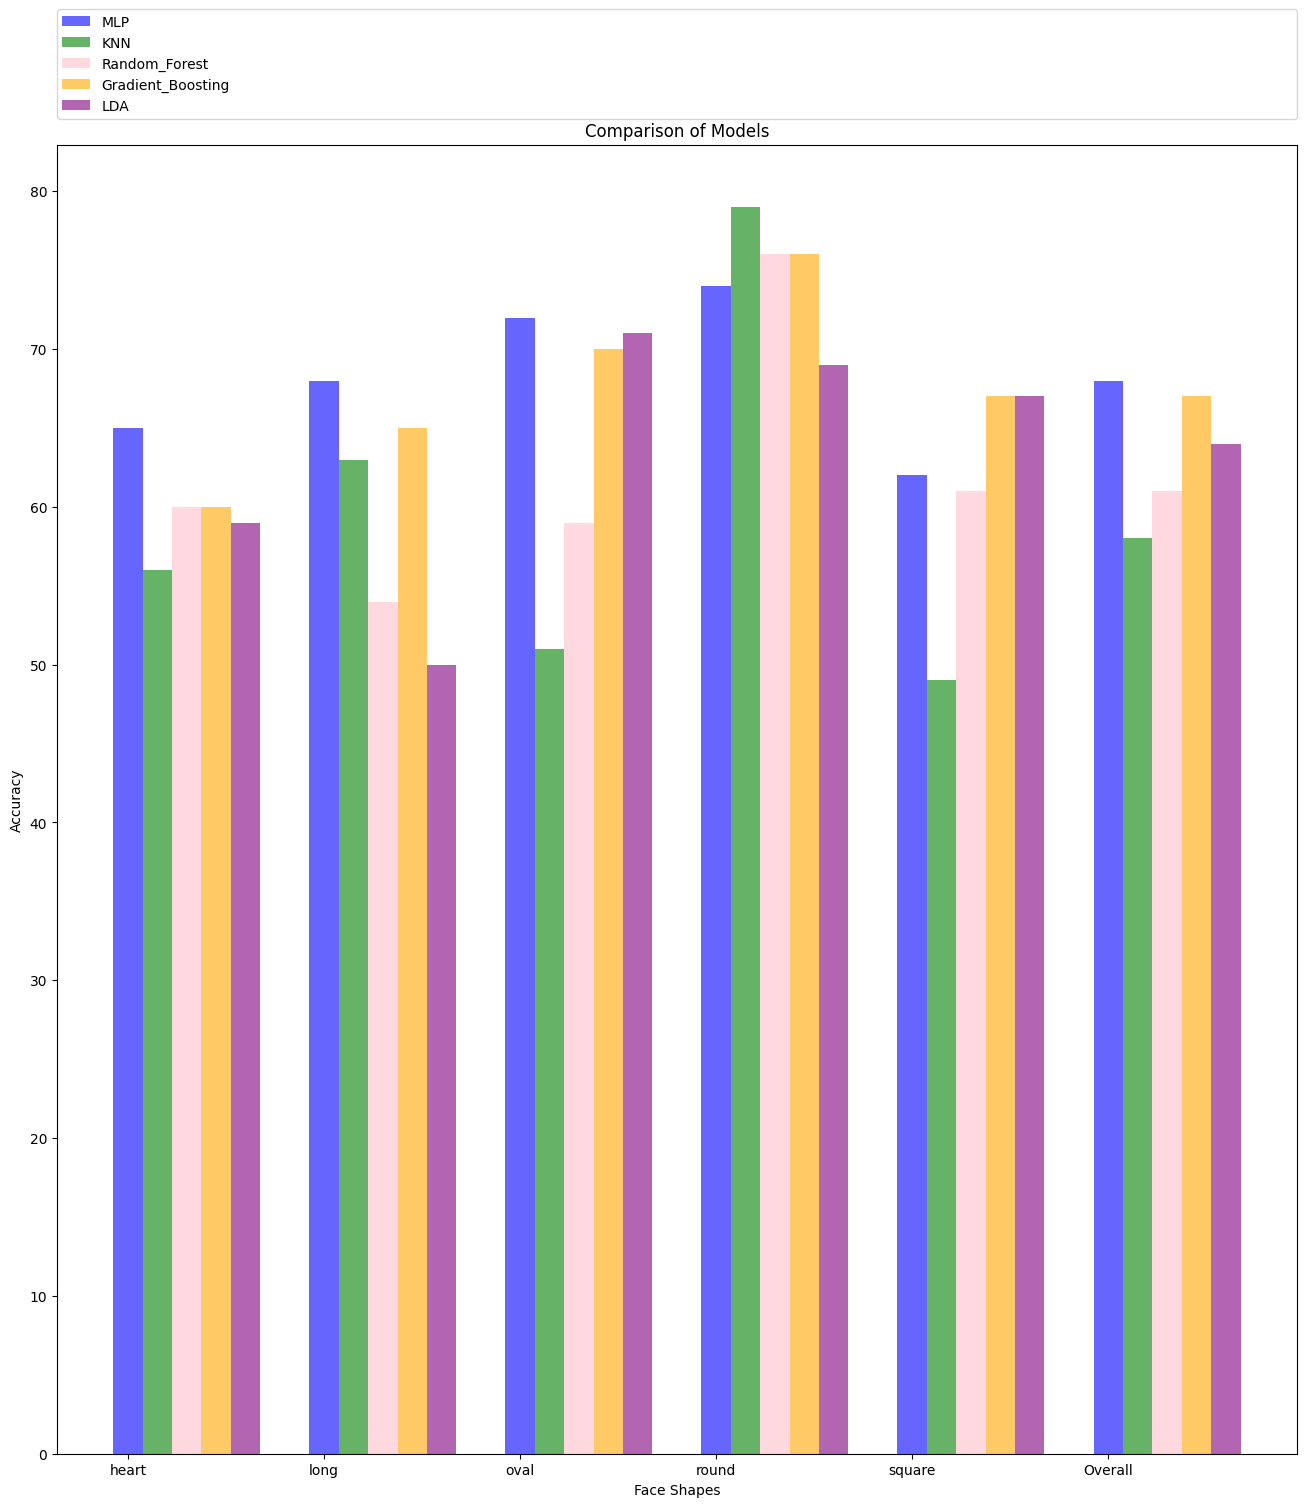

In [28]:
import matplotlib.pyplot as plt

def model_graph():
    ind = np.arange(6)  # the x locations for the groups
    width = 0.15       # the width of the bars

    fig, ax = plt.subplots(figsize=(16, 17))
    al = 0.6
    rects1 = ax.bar(ind, results_df['MLP'], width, color='blue',alpha= al,tick_label = results_df['shape'])
    rects2 = ax.bar(ind + width, results_df['KNN'], width, color='green',alpha= al)
    rects3 = ax.bar(ind + width*2, results_df['Random_Forest'], width, color='pink',alpha= al)
    rects4 = ax.bar(ind + width*3, results_df['Gradient_Boosting'], width, color='orange',alpha= al)
    rects5 = ax.bar(ind + width*4, results_df['LDA'], width, color='purple',alpha= al)

    plt.legend(results_df.iloc[0:0,1:7],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)


    plt.ylabel('Accuracy')
    plt.xlabel('Face Shapes')
    plt.title('Comparison of Models')
    plt.show()

model_graph()

In [29]:

results_df

,shape,MLP,KNN,Random_Forest,Gradient_Boosting,LDA
0,heart,65.0,56.0,60.0,60.0,59.0
1,long,68.0,63.0,54.0,65.0,50.0
2,oval,72.0,51.0,59.0,70.0,71.0
3,round,74.0,79.0,76.0,76.0,69.0
4,square,62.0,49.0,61.0,67.0,67.0
5,Overall,68.0,58.0,61.0,67.0,64.0


In [30]:
import joblib

# LDA model
lda_param_search.fit(X_train_pca, Y_train)
joblib.dump(lda_param_search, 'lda_model.pkl')

# Gradient Boosting model
gb_best.fit(X_train_pca, Y_train)
joblib.dump(gb_best, 'gb_model.pkl')

# Random Forest model
rf_best.fit(X_train_pca, Y_train)
joblib.dump(rf_best, 'rf_model.pkl')

# KNN model
neigh.fit(X_train_pca, Y_train)
joblib.dump(neigh, 'knn_model.pkl')

# MLP model
mlp_best.fit(X_train_pca, Y_train)
joblib.dump(mlp_best, 'mlp_model.pkl')

print("All models have been saved as .pkl files!")


All models have been saved as .pkl files!


In [31]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import uuid
import pathlib

# Initialize the style dataframe
style_df = pd.DataFrame(columns=['face_shape', 'hair_length', 'location', 'filename', 'score'])

# Function to process and populate the style dataframe
def process_rec_pics(style_df, image_dir="/content/drive/MyDrive/CV PROJECT/pics"):
    image_root = "/content/drive/MyDrive/CV PROJECT/rec_pics"
    dir_list = ['heart', 'long', 'oval', 'square', 'round']
    filenum = 0

    for dd in dir_list:
        image_dir = os.path.join(image_root, dd)
        sub_dirs = [q for q in pathlib.Path(image_dir).iterdir() if q.is_dir()]

        for sub in sub_dirs:
            for img_path in pathlib.Path(sub).iterdir():
                face_shape = os.path.basename(os.path.dirname(os.path.dirname(img_path))).lower()
                hair_length = os.path.basename(os.path.dirname(img_path)).lower()
                filename = os.path.basename(img_path)

                random.seed(filenum)
                rand_score = random.randint(25, 75)

                style_df.loc[filenum] = [
                    face_shape, hair_length, str(img_path), filename, rand_score
                ]
                filenum += 1

    print(f"Total styles loaded: {filenum}")
    return filenum


# Recommender system
def run_recommender(style_df, test_shape):
    # Normalize dataframe
    style_df['face_shape'] = style_df['face_shape'].str.lower()
    style_df['hair_length'] = style_df['hair_length'].str.lower()

    name = input("What is your name? ")
    print(f"Hello, {name}!")

    face_shape_input = test_shape.lower()
    if face_shape_input not in ['heart', 'long', 'oval', 'round', 'square']:
        face_shape_input = input("What is your face shape? ").lower()

    updo_input = input("Would you like to see up-dos? (Y/N): ").lower()
    if updo_input in ['n', 'no']:
        hair_length_input = input("Is your hair short (shoulder-length or shorter) or long? ").lower()
        if hair_length_input in ['short', 's']:
            hair_length_input = 'short'
        elif hair_length_input in ['long', 'l', 'longer']:
            hair_length_input = 'long'
        else:
            print("Invalid hair length. Defaulting to 'long'.")
            hair_length_input = 'long'
    else:
        hair_length_input = 'updo'

    print(f"Hair length: {hair_length_input}")
    print(f"Face shape: {face_shape_input}")

    # Debug
    print("Available face shapes in data:", style_df['face_shape'].unique())
    print("Available hair lengths in data:", style_df['hair_length'].unique())

    recommended_df = style_df[
        (style_df['face_shape'] == face_shape_input) &
        (style_df['hair_length'] == hair_length_input)
    ].sort_values('score', ascending=False).reset_index(drop=True)

    if recommended_df.empty:
        print("No styles found for the given inputs. Showing top styles instead.")
        recommended_df = style_df.sort_values('score', ascending=False).head(6)
    else:
        recommended_df = recommended_df.head(6)

    print("Number of recommendations found:", len(recommended_df))

    # Plot
    plt.figure(figsize=(15, 8))
    plt.subplots_adjust(bottom=0.05, top=0.9, hspace=0.4)

    try:
        font = ImageFont.truetype("/content/drive/MyDrive/CV PROJECT/fonts/Arial.ttf", 60)
    except IOError:
        font = ImageFont.load_default()

    for i in range(len(recommended_df)):
        img_path = recommended_df.iloc[i]['location'].replace('\\', '/')
        try:
            img = Image.open(img_path)
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            continue
        plt.subplot(2, 3, i + 1)
        draw = ImageDraw.Draw(img)
        plt.title(f"Style {i + 1}", fontsize=16)
        plt.xlabel(f"Score: {recommended_df.iloc[i]['score']}", fontsize=12)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        img.close()

    plt.show()

    fav = input("Which style is your favorite? (1-6): ")
    yuck = input("Which style is your least favorite? (1-6): ")

    for row in range(len(recommended_df)):
        fn = recommended_df.at[row, 'filename']
        srow = style_df.index[style_df['filename'] == fn].tolist()
        if srow:
            srow = srow[0]
            if str(row + 1) == str(fav):
                style_df.at[srow, 'score'] += 5
            if str(row + 1) == str(yuck):
                style_df.at[srow, 'score'] -= 5

    output_file = run_recommender_face_shape(style_df, face_shape_input, hair_length_input)
    if output_file:
        print(f"Recommended hairstyle image saved to: {output_file}")
        try:
            img = Image.open(output_file)
            img.show()
        except:
            from IPython.display import Image as IPImage, display
            display(IPImage(filename=output_file))


# Final recommendation collage
def run_recommender_face_shape(style_df, test_shape, hair_length_input):
    face_shape_input = test_shape.lower()
    hair_length_input = hair_length_input.lower()

    recommended_df = style_df[
        (style_df['face_shape'] == face_shape_input) &
        (style_df['hair_length'] == hair_length_input)
    ].sort_values('score', ascending=False).reset_index(drop=True)

    if recommended_df.empty:
        print("No styles found for final image. Showing top styles instead.")
        recommended_df = style_df.sort_values('score', ascending=False).head(6)
    else:
        recommended_df = recommended_df.head(6)

    plt.figure(figsize=(12, 6))
    plt.subplots_adjust(bottom=0.05, top=0.9, hspace=0.4)

    for i in range(len(recommended_df)):
        img_path = recommended_df.iloc[i]['location'].replace('\\', '/')
        try:
            img = Image.open(img_path)
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            continue
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Style {i + 1}", fontsize=14)
        plt.xlabel(f"Score: {recommended_df.iloc[i]['score']}", fontsize=10)
        plt.xticks([])
        plt.yticks([])
        img.close()

    os.makedirs("output", exist_ok=True)
    img_filename = f"output/output_{uuid.uuid4()}.png"
    plt.savefig(img_filename)
    plt.close()
    return img_filename


In [32]:
import requests
from PIL import Image, ImageDraw
import math
import numpy as np
import pathlib
from pathlib import Path
import os
import random

# Function to calculate distance between two points
def distance(p1,p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    return math.sqrt(dx*dx+dy*dy)

# Function to scale, rotate, and translate the image
def scale_rotate_translate(image, angle, center = None, new_center = None, scale = None, resample=Image.BICUBIC):
    if (scale is None) and (center is None):
        return image.rotate(angle=angle, resample=resample)
    nx,ny = x,y = center
    sx=sy=1.0
    if new_center:
        (nx,ny) = new_center
    if scale:
        (sx,sy) = (scale, scale)
    cosine = math.cos(angle)
    sine = math.sin(angle)
    a = cosine/sx
    b = sine/sx
    c = x-nx*a-ny*b
    d = -sine/sy
    e = cosine/sy
    f = y-nx*d-ny*e
    return image.transform(image.size, Image.AFFINE, (a,b,c,d,e,f), resample=resample)

# Function to crop the face in the image
def crop_face(image, eye_left=(0, 0), eye_right=(0, 0), offset_pct=(0.3, 0.3), dest_sz=(600, 600)):
    offset_h = math.floor(offset_pct[0] * dest_sz[0])
    offset_v = math.floor(offset_pct[1] * dest_sz[1])

    eye_direction = (eye_right[0] - eye_left[0], eye_right[1] - eye_left[1])
    rotation = -math.atan2(float(eye_direction[1]), float(eye_direction[0]))
    dist = distance(eye_left, eye_right)

    reference = dest_sz[0] - 2.0 * offset_h
    scale = float(dist) / float(reference)

    image = scale_rotate_translate(image, center=eye_left, angle=rotation, scale=1.0)

    crop_xy = (eye_left[0] - scale * offset_h, eye_left[1] - scale * offset_v)
    crop_size = (dest_sz[0] * scale, dest_sz[1] * scale)

    image = image.crop((
        int(crop_xy[0]),
        int(crop_xy[1]),
        int(crop_xy[0] + crop_size[0]),
        int(crop_xy[1] + crop_size[1])
    ))

    # Replace deprecated ANTIALIAS with Resampling.LANCZOS
    try:
        resample_filter = Image.Resampling.LANCZOS
    except AttributeError:
        resample_filter = Image.LANCZOS  # Fallback for older Pillow

    image = image.resize(dest_sz, resample=resample_filter)

    return image
# Function to process and extract face features (without face_recognition)
def process_image(image_select, filenum):
    pts = []
    image = Image.open(image_select)

    # Example points for the sake of illustration
    # Replace this with actual face landmarks or manually defined points if needed
    eye_left = (150, 100)
    eye_right = (250, 100)
    chin = (200, 300)

    # Rotate and crop the face based on the eyes as the pivot point
    crop_image = crop_face(image, eye_left=eye_left, eye_right=eye_right, offset_pct=(0.34,0.34), dest_sz=(300, 300))

    try:
        crop_image.save(str(image_select) + "_NEW_cropped.jpg")
    except:
        return

    nn = str(image_select) + "_NEW_cropped.jpg"
    pts = []

    # Example of manually defined measurements (use your own method here to extract points)
    a = 150   # Example left side of face x coordinate
    b = 100   # Example left side of face y coordinate
    c = 250   # Example right side of face x coordinate
    d = 100   # Example right side of face y coordinate

    e = 200   # Example chin x coordinate
    f = 300   # Example chin y coordinate

    face_width = np.sqrt(np.square(a - c) + np.square(b - d))
    pts.append(face_width)
    face_height = np.sqrt(np.square(e - 200) + np.square(f - 300)) * 2   # Example height calculation
    pts.append(face_height)

    height_to_width = face_height / face_width
    pts.append(height_to_width)

    # JAW width (example points)
    jaw_width = np.sqrt(np.square(180 - 220) + np.square(220 - 240))
    pts.append(jaw_width)
    jaw_width_to_face_width = jaw_width / face_width
    pts.append(jaw_width_to_face_width)

    # Mid-JAW width (example points)
    mid_jaw_width = np.sqrt(np.square(170 - 230) + np.square(200 - 220))
    pts.append(mid_jaw_width)
    mid_jaw_width_to_jaw_width = mid_jaw_width / jaw_width
    pts.append(mid_jaw_width_to_jaw_width)

    # Save results in dataframe (assuming df is already defined elsewhere)
    df.loc[filenum] = np.array(pts)



In [37]:
from fer import FER
from deepface import DeepFace

# Function to detect emotions using FER
def detect_emotion(image):
    detector = FER()
    emotion, score = detector.top_emotion(image)
    return emotion, score

# Function to use DeepFace for emotion detection
def detect_emotion_deepface(image_path):
    result = DeepFace.analyze(image_path, actions=['emotion'])
    return result[0]['dominant_emotion']

from PIL import Image
import numpy as np

def make_face_df_save(image_select, filenum, df):
    try:
        # Load image
        image = Image.open(image_select)

        # Dummy eye coordinates — replace with detector if possible
        lex, ley = 100, 150
        rex, rey = 200, 150

        # Crop the face
        crop_image = crop_face(
            image,
            eye_left=(lex, ley),
            eye_right=(rex, rey),
            offset_pct=(0.34, 0.34),
            dest_sz=(300, 300)
        )

        # Save cropped image
        crop_path = f"{image_select}_NEW_cropped.jpg"
        crop_image.save(crop_path)

        # Detect emotion
        emotion = detect_emotion_deepface(crop_path)
        print(f"Detected emotion: {emotion}")

        # Dummy features + emotion
        pts = [0] * 137
        pts.append(emotion)

        if len(pts) != len(df.columns):
            print(f"Error: Feature count {len(pts)} does not match DataFrame columns {len(df.columns)}")
            return

        # Save row to DataFrame
        df.loc[filenum] = np.array(pts)
        print(f"Updated DataFrame with face data for file {filenum}")

    except Exception as e:
        print(f"[Skipped] {image_select} due to error: {e}")


25-05-06 16:29:24 - Directory /root/.deepface has been created
25-05-06 16:29:24 - Directory /root/.deepface/weights has been created


In [38]:
import pandas as pd

# 137 feature values + 1 for emotion = 138 columns
df = pd.DataFrame(columns=[f'f{i}' for i in range(138)])

my_photo = '/content/drive/MyDrive/CV PROJECT/pics/heart/Amanda S 2.jpg_NEW_cropped.jpg'
file_num = 0

make_face_df_save(my_photo, file_num, df)

# Print the updated row
print(df.loc[file_num])


25-05-06 16:29:32 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 67.6MB/s]


Detected emotion: happy
Updated DataFrame with face data for file 0
f0          0
f1          0
f2          0
f3          0
f4          0
        ...  
f133        0
f134        0
f135        0
f136        0
f137    happy
Name: 0, Length: 138, dtype: object


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Step 1: Load and inspect the data
df = pd.read_csv("/content/all_features.csv")  # Replace with your actual data source

# Check the column names to verify the correct one for target
print(df.columns)

# Step 2: Handle missing values - Impute missing values with the mean for numeric columns
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=['classified_shape', 'Unnamed: 0', 'filenum', 'filename'])), columns=df.drop(columns=['classified_shape', 'Unnamed: 0', 'filenum', 'filename']).columns)

# Step 3: Encode the target variable (emotion or shape classification)
label_encoder = LabelEncoder()
df['classified_shape'] = label_encoder.fit_transform(df['classified_shape'])

# Step 4: Prepare data for training (exclude non-relevant columns for features, and use 'classified_shape' as target)
X = df_imputed  # Features (after imputation)
y = df['classified_shape']  # Target (encoded 'classified_shape')

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training data
X_test_scaled = scaler.transform(X_test)  # Transform test data

# Step 7: Define and train the MLP model
best_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
best_mlp.fit(X_train_scaled, y_train)  # Train the model

# Step 8: Evaluate the model
train_score = best_mlp.score(X_train_scaled, y_train)
test_score = best_mlp.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_score}")
print(f"Test Accuracy: {test_score}")

# Step 9: Make predictions for a specific test row (example: file_num = 2035)
file_num = 137

# Ensure the file_num exists in the DataFrame index
if file_num in df.index:
    # Extract the features of the row
    test_row = df.loc[file_num].drop(['classified_shape', 'Unnamed: 0', 'filenum', 'filename'])  # Exclude non-relevant columns
    test_row_imputed = imputer.transform([test_row])  # Impute missing values for the test row
    test_row_scaled = scaler.transform(test_row_imputed)  # Scale the row

    # Predict the shape for the given test row
    test_shape = best_mlp.predict(test_row_scaled)
    predicted_shape = label_encoder.inverse_transform(test_shape)  # Convert the predicted label back to the original shape
    print(f"Predicted shape for file {file_num}: {predicted_shape[0]}")
else:
    print(f"file_num {file_num} is not a valid index in the DataFrame. Available indices: {df.index.tolist()[:10]}...")  # Print the first 10 indices


Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       'Width', 'Height', 'H_W_Ratio', 'Jaw_width', 'J_F_Ratio', 'MJ_width',
       'MJ_J_width', 'filenum', 'filename', 'classified_shape'],
      dtype='object', length=171)
Train Accuracy: 0.9942575881870386
Test Accuracy: 0.6721311475409836
Predicted shape for file 137: heart


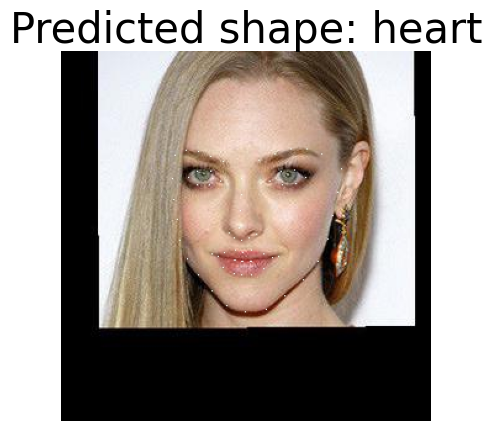

In [40]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.preprocessing import StandardScaler

# Check if the 'file_num' exists in the index
file_num = 137

# Check if the 'file_num' exists in the index of the dataframe
if file_num in df.index:
    # Step 1: Prepare the test row (for example, file_num = 2035)
    test_row = df.loc[file_num].drop(['classified_shape', 'Unnamed: 0', 'filenum', 'filename'])

    # Step 2: Scale the test row using the scaler that was fitted on the training data
    test_row_scaled = scaler.transform([test_row])  # Ensure the data is 2D as required by the model

    # Step 3: Use the model to predict the shape of the given test row
    test_shape = best_mlp.predict(test_row_scaled)

    # Step 4: Load the image for this test row (assuming 'new_photo' contains the file path)
    new_photo = "/content/drive/MyDrive/CV PROJECT/pics/heart/Amanda S 2.jpg_NEW_cropped.jpg_NEW_rotated_pts.jpg"  # Replace with the actual image path
    img = Image.open(new_photo)
    draw = ImageDraw.Draw(img)

    # Step 5: Display the prediction as the title of the image
    plt.title(f"Predicted shape: {predicted_shape[0]}", fontsize=30)
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()
else:
    print(f"The file number {file_num} does not exist in the DataFrame index.")


Total styles loaded: 1164
What is your name? hon
Hello, hon!
Would you like to see up-dos? (Y/N): N
Is your hair short (shoulder-length or shorter) or long? long
Hair length: long
Face shape: heart
Available face shapes in data: ['heart' 'long' 'oval' 'square' 'round']
Available hair lengths in data: ['short' 'long' 'updo']
Number of recommendations found: 6


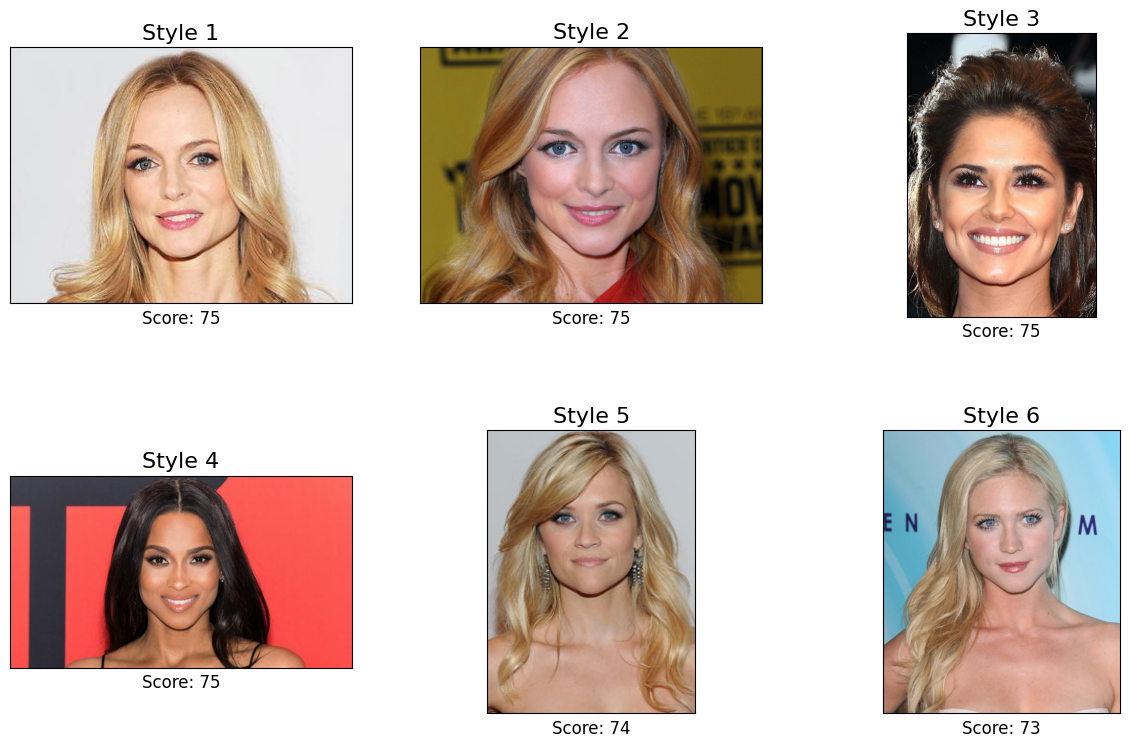

In [ ]:
4# Load styles first
process_rec_pics(style_df)

# Then run the recommender
run_recommender(style_df,predicted_shape[0])
